In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df.drop(columns=['Lat', 'Long'], inplace=True)
df.set_index(['Country/Region', 'Province/State'], inplace=True)
df = df.transpose()

In [3]:
dfus = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
dfus['Province_State'] += '/' + dfus['Admin2'].fillna('')
dfus.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Lat', 'Long_', 'Combined_Key', 'Population'], inplace=True)
dfus.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'}, inplace=True)
dfus.set_index(['Country/Region', 'Province/State'], inplace=True)
dfus = dfus.transpose()
for col in dfus['US'].columns:
    df['US', col] = dfus['US', col]
del dfus

states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
for state in states:
    df['US', state] = df['US'][df['US'].columns[df['US'].columns.str.startswith(state).fillna(False)]].sum(axis=1).copy()

In [4]:
def plt_country(country, province=np.nan, goal=10, window=1, daily=False, plot=True):
    series = df[country]
    fmt = '%m/%d/%y'
    if province not in series.columns and np.isnan(province):
        series = series.sum(axis=1)
    else:
        series = series[province]
    series = series[series > 0]
    dates = np.fromiter(map(lambda x: datetime.strptime(x, fmt).timestamp(), series.index), dtype=float)
    diff = num_loc(dates, series, goal)
    if diff is None:
        return
    series = series.rolling(window).mean().fillna(0)
    if daily:
        series = series.diff().fillna(0)
    diffs = (dates - diff)/(3600*24)
    label = '%s/%s' % (country, province) if isinstance(province, str) else '%s' % country
    if plot:
        plt.plot(diffs, series, linestyle='-', marker='o', label=label)
    return diffs, series, label

In [5]:
def num_loc(dates, series, goal):
    prev = (0, 0)
    for date, val in zip(dates, series):
        if val >= goal:
            r = (goal - prev[1])/(val - prev[1])
            return prev[0] + r*(date - prev[0])
        prev = (date, val)

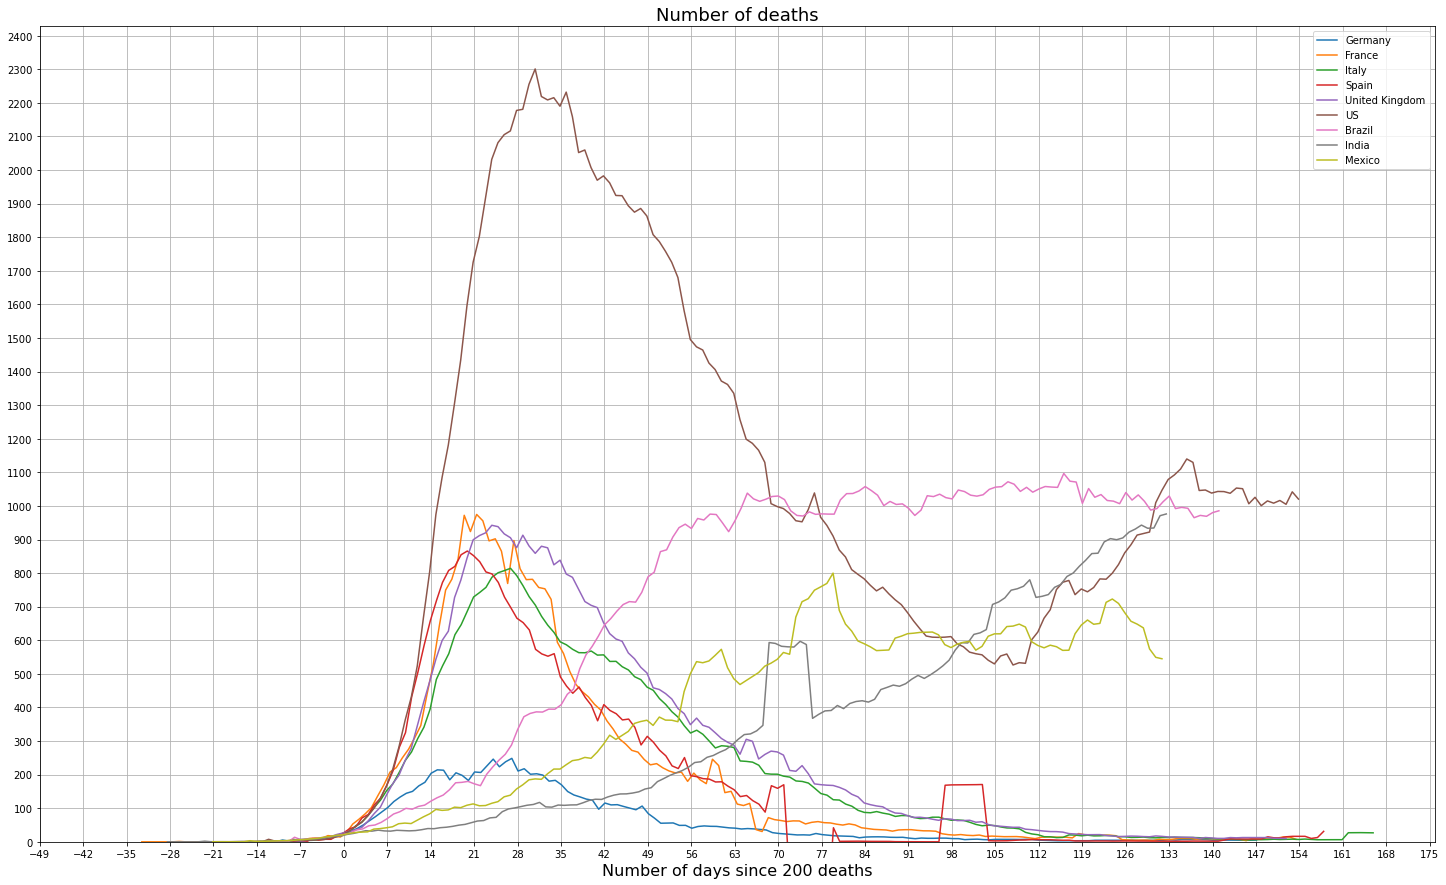

In [6]:
plt.figure(figsize=(25, 15))
plt.title('Number of deaths', fontsize=18)
goal = 200
plt.xlabel('Number of days since %d deaths' % goal, fontsize=16)
plt.grid()
params = ('Germany', 'France', 'Italy', 'Spain', 'United Kingdom', 'US', 'Brazil', 'India', 'Mexico')
#params = (('US', 'Illinois'), ('US', 'Wisconsin'), ('US', 'Minnesota'))
#params = [('US', state) for state in states]# + [c for c in df.columns if (not isinstance(c[1], str)) and np.isnan(c[1])]

toplot = []
for p in params:
    if isinstance(p, str):
        p = (p,)
    res = plt_country(*p, goal=goal, window=7, daily=True, plot=False)
    if res is not None:
        toplot.append(res)

#toplot.sort(key=lambda d: d[1][-10:].mean())[:10]

# toplot = sorted(
#     filter(lambda d: d[1][-1] > 20, toplot),
#     key=lambda d: -d[1].pct_change()[-10:].mean())[:8]

for diffs, series, label in toplot:
    plt.plot(diffs, series, linestyle='-', marker=None, label=label)

#plt_country('US', 'New York/New York', goal=goal)
#plt_country('Korea, South', goal=goal)
xmin, xmax = plt.xlim()
plt.xticks(ticks=np.arange(7*(xmin//7), 7*(xmax//7) + 7, 7))
#ym = 1000
ym = plt.ylim()[1]
if ym > 300:
    step = 100*(max(100, ym/30)//100)
else:
    step = 10*(max(10, ym/30)//10)
plt.yticks(ticks=np.arange(0, ym + step, step))
plt.ylim((0, ym))
plt.legend(loc='upper right')
plt.savefig('analysis.jpg')

In [7]:
ny = df['US'][df['US'].columns[df['US'].columns.fillna('').str.startswith('Illinois/')]]
ny = ny.iloc[-7:].transpose()
#ny['New York/New York']

In [18]:
(ny['7/6/20'] - ny['7/7/20']).sort_values()

Province/State
Illinois/Unassigned    -210
Illinois/Cook           -21
Illinois/DuPage          -2
Illinois/Will            -2
Illinois/Lake            -2
Illinois/Winnebago       -1
Illinois/Stephenson      -1
Illinois/St. Clair       -1
Illinois/Rock Island     -1
Illinois/Sangamon        -1
Illinois/Kane            -1
Illinois/Kendall         -1
Illinois/Madison         -1
Illinois/Peoria          -1
Illinois/McHenry         -1
Illinois/Moultrie         0
Illinois/Ogle             0
Illinois/Morgan           0
Illinois/Montgomery       0
Illinois/Menard           0
Illinois/Mercer           0
Illinois/McLean           0
Illinois/Perry            0
Illinois/Massac           0
Illinois/Mason            0
Illinois/Marshall         0
Illinois/Marion           0
Illinois/Macoupin         0
Illinois/Macon            0
Illinois/Monroe           0
                       ... 
Illinois/Boone            0
Illinois/Bond             0
Illinois/Alexander        0
Illinois/Effingham        0
Illin

In [16]:
df['US'].columns[df['US'].columns.fillna('').str.startswith('New Jersey/')]

Index(['New Jersey/Atlantic', 'New Jersey/Bergen', 'New Jersey/Burlington',
       'New Jersey/Camden', 'New Jersey/Cape May', 'New Jersey/Cumberland',
       'New Jersey/Essex', 'New Jersey/Gloucester', 'New Jersey/Hudson',
       'New Jersey/Hunterdon', 'New Jersey/Mercer', 'New Jersey/Middlesex',
       'New Jersey/Monmouth', 'New Jersey/Morris', 'New Jersey/Ocean',
       'New Jersey/Passaic', 'New Jersey/Salem', 'New Jersey/Somerset',
       'New Jersey/Sussex', 'New Jersey/Union', 'New Jersey/Warren',
       'New Jersey/Out of NJ', 'New Jersey/Unassigned'],
      dtype='object', name='Province/State')

In [9]:
x = df[[('US', s) for s in states]].transpose()

In [12]:
(x['7/7/20']-x['7/6/20']).sort_values()

Country/Region  Province/State
US              Nebraska           -1
                West Virginia       0
                Montana             0
                Connecticut         0
                Vermont             0
                Hawaii              0
                Idaho               0
                Wyoming             1
                Alaska              1
                South Dakota        1
                Maine               1
                New Hampshire       2
                Delaware            2
                Minnesota           3
                North Dakota        4
                Kansas              4
                Utah                4
                New Mexico          4
                Oregon              5
                Oklahoma            5
                Colorado            5
                Kentucky            9
                Rhode Island        9
                Iowa                9
                Wisconsin           9
                Ark